# Modelado de Smile, LocVol y Calibración de Modelo de Volatilidad Stocástica

In [1]:
# Importamos QuantLib
import QuantLib as ql
import math

In [2]:
# Definimos las convenciones de day count y calendario
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(6, 11, 2015)

spot = 659.37
ql.Settings.instance().evaluationDate = calculation_date

dividend_yield = ql.QuoteHandle(ql.SimpleQuote(0.0))
risk_free_rate = 0.01
dividend_rate = 0.0
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [3]:
# Lo que vemos a continuacion son matrices de vencimiento, strike y las volatilidades correspondientes
# sacadas de un ejemplo de quantlib
# Las volatilidades son lognormales, y pueden ser interpoladas para armar la sabana 
expiration_dates = [ql.Date(6,12,2015), ql.Date(6,1,2016), ql.Date(6,2,2016),
                    ql.Date(6,3,2016), ql.Date(6,4,2016), ql.Date(6,5,2016), 
                    ql.Date(6,6,2016), ql.Date(6,7,2016), ql.Date(6,8,2016),
                    ql.Date(6,9,2016), ql.Date(6,10,2016), ql.Date(6,11,2016), 
                    ql.Date(6,12,2016), ql.Date(6,1,2017), ql.Date(6,2,2017),
                    ql.Date(6,3,2017), ql.Date(6,4,2017), ql.Date(6,5,2017), 
                    ql.Date(6,6,2017), ql.Date(6,7,2017), ql.Date(6,8,2017),
                    ql.Date(6,9,2017), ql.Date(6,10,2017), ql.Date(6,11,2017)]
strikes = [527.50, 560.46, 593.43, 626.40, 659.37, 692.34, 725.31, 758.28]
data = [
[0.37819, 0.34177, 0.30394, 0.27832, 0.26453, 0.25916, 0.25941, 0.26127],
[0.3445, 0.31769, 0.2933, 0.27614, 0.26575, 0.25729, 0.25228, 0.25202],
[0.37419, 0.35372, 0.33729, 0.32492, 0.31601, 0.30883, 0.30036, 0.29568],
[0.37498, 0.35847, 0.34475, 0.33399, 0.32715, 0.31943, 0.31098, 0.30506],
[0.35941, 0.34516, 0.33296, 0.32275, 0.31867, 0.30969, 0.30239, 0.29631],
[0.35521, 0.34242, 0.33154, 0.3219, 0.31948, 0.31096, 0.30424, 0.2984],
[0.35442, 0.34267, 0.33288, 0.32374, 0.32245, 0.31474, 0.30838, 0.30283],
[0.35384, 0.34286, 0.33386, 0.32507, 0.3246, 0.31745, 0.31135, 0.306],
[0.35338, 0.343, 0.33464, 0.32614, 0.3263, 0.31961, 0.31371, 0.30852],
[0.35301, 0.34312, 0.33526, 0.32698, 0.32766, 0.32132, 0.31558, 0.31052],
[0.35272, 0.34322, 0.33574, 0.32765, 0.32873, 0.32267, 0.31705, 0.31209],
[0.35246, 0.3433, 0.33617, 0.32822, 0.32965, 0.32383, 0.31831, 0.31344],
[0.35226, 0.34336, 0.33651, 0.32869, 0.3304, 0.32477, 0.31934, 0.31453],
[0.35207, 0.34342, 0.33681, 0.32911, 0.33106, 0.32561, 0.32025, 0.3155],
[0.35171, 0.34327, 0.33679, 0.32931, 0.3319, 0.32665, 0.32139, 0.31675],
[0.35128, 0.343, 0.33658, 0.32937, 0.33276, 0.32769, 0.32255, 0.31802],
[0.35086, 0.34274, 0.33637, 0.32943, 0.3336, 0.32872, 0.32368, 0.31927],
[0.35049, 0.34252, 0.33618, 0.32948, 0.33432, 0.32959, 0.32465, 0.32034],
[0.35016, 0.34231, 0.33602, 0.32953, 0.33498, 0.3304, 0.32554, 0.32132],
[0.34986, 0.34213, 0.33587, 0.32957, 0.33556, 0.3311, 0.32631, 0.32217],
[0.34959, 0.34196, 0.33573, 0.32961, 0.3361, 0.33176, 0.32704, 0.32296],
[0.34934, 0.34181, 0.33561, 0.32964, 0.33658, 0.33235, 0.32769, 0.32368],
[0.34912, 0.34167, 0.3355, 0.32967, 0.33701, 0.33288, 0.32827, 0.32432],
[0.34891, 0.34154, 0.33539, 0.3297, 0.33742, 0.33337, 0.32881, 0.32492]]

In [4]:
# Toda la Data anterior la tenemos que poner en un objecto quantlib Matrix.
# La matriz de quantlib necesita que los strike sean las filas
# y los vencimientos las columnas, por eso permutamos [i] y [j]
# La matriz de quantlib se puede usar después para armar otras sabanas.
implied_vols = ql.Matrix(len(strikes), len(expiration_dates))
for i in range(implied_vols.rows()):
    for j in range(implied_vols.columns()):
        implied_vols[i][j] = data[j][i]

In [5]:
# Con el metodo BlackVarianceSurface armamos nuestra superficie
black_var_surface = ql.BlackVarianceSurface(
    calculation_date, calendar, 
    expiration_dates, strikes, 
    implied_vols, day_count)

In [6]:
# Las volatilidades para cualquier strike y vencimiento se puede
# obtener usando el meotodo blackVol
strike = 600.0
expiry = 1.2 # years
black_var_surface.blackVol(expiry, strike)

0.3352982638587421

## Visualización 

In [7]:
import numpy as np
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

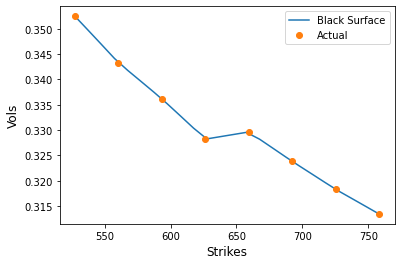

In [8]:
# Dado una fecha de vencimiento podemos ver la curva vol/strike

strikes_grid = np.arange(strikes[0], strikes[-1],10)
expiry = 1.0 # años
implied_vols = [black_var_surface.blackVol(expiry, s) 
                for s in strikes_grid] # se puede interpolar acá
actual_data = data[11] # data elegida para el vencimiento

fig, ax = plt.subplots()
ax.plot(strikes_grid, implied_vols, label="Black Surface")
ax.plot(strikes, actual_data, "o", label="Actual")
ax.set_xlabel("Strikes", size=12)
ax.set_ylabel("Vols", size=12)
legend = ax.legend(loc="upper right")

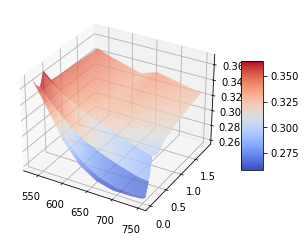

In [9]:
# Ahora visualizamos la superficie completa
plot_years = np.arange(0, 2, 0.1)
plot_strikes = np.arange(535, 750, 1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([black_var_surface.blackVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

## Volatilidad Local de Dupire

In [10]:
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(black_var_surface), 
    flat_ts, 
    dividend_ts, 
    spot)

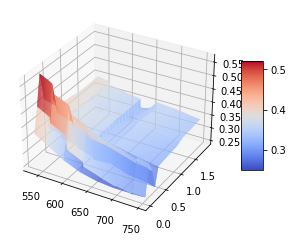

In [11]:
plot_years = np.arange(0, 2, 0.1)
plot_strikes = np.arange(535, 750, 1)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([local_vol_surface.localVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

### IMPORTANTE:
El priceo correcto de volatilidad local require que la sabana sea "arbitrage free". Si esto no ocurre, pueden ocurrir probabilidades de transición negativas o volatilidades locales negativas. Quanlib carece de "Fengler's arbitrage free smoothing" https://core.ac.uk/reader/6978470

Cuando usamos un arbitrary smoothing, podemos ver que la sabana de volatilidad local conduce a volatilidades negativas

RuntimeError: negative local vol^2 at strike 655 and time 0.75; the black vol surface is not smooth enough

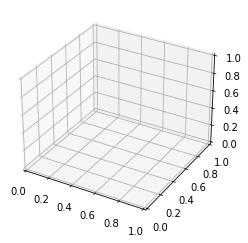

In [14]:
black_var_surface.setInterpolation("bicubic")
local_vol_surface = ql.LocalVolSurface(
    ql.BlackVolTermStructureHandle(black_var_surface), 
    flat_ts, 
    dividend_ts, 
    spot)
plot_years = np.arange(0, 2, 0.15)
plot_strikes = np.arange(535, 750, 10)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
X, Y = np.meshgrid(plot_strikes, plot_years)
Z = np.array([local_vol_surface.localVol(y, float(x)) 
              for xr, yr in zip(X, Y) 
                  for x, y in zip(xr,yr) ]
             ).reshape(len(X), len(X[0]))

surf = ax.plot_surface(Y,X, Z, rstride=1, cstride=1, cmap=cm.coolwarm, 
                linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)

#### VER EL ERROR!!!!
"negative local vol^2 at strike 655 and time 0.75; the black vol surface is not smooth enough".

Tal como comentabamos arriba, esto pasa cuando elegimos arbitráriamente una interpolación.

## Calibración del Modelo de Heston

Las ecuaciones que definen al model son:

$ dS_{t} = \mu Sdt+ \sqrt{\nu}SdW_{1} $

$ d\nu_{t} =\kappa(\theta - \nu)dt + \sigma\sqrt{\nu}dW_{2}$

$dW1_{2}dW_{2} = \rho dt $

Arriba lo que podemos ver es que el Stock se mueve como un proceso estocástico que depende de la varianza que es a la vez otro proceso estocástico. El segundo es un proceso de reversión a la media y tiene un desvio constante $\sigma$ . La correlación entre procesos es $\rho$ .

Veamos cómo podemos calibrar el modelo de Heston para algunas cotizaciones del mercado. Como ejemplo, digamos que estamos interesados ​​en negociar opciones con vencimiento a 1 año. Por lo tanto, calibraremos el modelo de Heston para que se ajuste a las cotizaciones de volatilidad del mercado con un vencimiento de un año. Antes de hacer eso, necesitamos construir el motor de precios que necesitarían las rutinas de calibración.

In [15]:
# Parámetros elegidos al azar
v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; sigma = 0.5;

process = ql.HestonProcess(flat_ts, dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(spot)), 
                           v0, kappa, theta, sigma, rho)
model = ql.HestonModel(process)
engine = ql.AnalyticHestonEngine(model) 

Ahora que tenemos el modelo Heston y un motor de precios, escojemos las cotizaciones con todas los strikes y el vencimiento de 1 año para calibrar el modelo Heston. Creamos el modelo auxiliar de Heston que se incluirá en las rutinas de calibración.


In [16]:
heston_helpers = []
black_var_surface.setInterpolation("bicubic")
one_year_idx = 11 # la fila 12 en data es para el vencimiento de 1 año
date = expiration_dates[one_year_idx]
for j, s in enumerate(strikes):
    t = (date - calculation_date )
    p = ql.Period(t, ql.Days)
    sigma = data[one_year_idx][j]
    helper = ql.HestonModelHelper(p, calendar, spot, s, 
                                  ql.QuoteHandle(ql.SimpleQuote(sigma)),
                                  flat_ts, 
                                  dividend_ts)
    helper.setPricingEngine(engine)
    heston_helpers.append(helper)

In [17]:
lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
model.calibrate(heston_helpers, lm, 
                 ql.EndCriteria(500, 50, 1.0e-8,1.0e-8, 1.0e-8))
theta, kappa, sigma, rho, v0 = model.params()

In [18]:
print( "theta = %f, kappa = %f, sigma = %f, rho = %f, v0 = %f" % (theta, kappa, sigma, rho, v0))


theta = 0.132329, kappa = 10.980882, sigma = 4.018086, rho = -0.351560, v0 = 0.065681


Veamos ahora el error de la calibración priceando las opciones utlizadas para calibrar utilizando el modelo calibrado y estimemos el error

In [19]:
avg = 0.0

print( "%15s %15s %15s %20s" % (
    "Strikes", "Market Value", 
     "Model Value", "Relative Error (%)"))
print("="*70)
for i, opt in enumerate(heston_helpers):
    err = (opt.modelValue()/opt.marketValue() - 1.0)
    print( "%15.2f %14.5f %15.5f %20.7f " % (
        strikes[i], opt.marketValue(), 
        opt.modelValue(), 
        100.0*(opt.modelValue()/opt.marketValue() - 1.0)))
    avg += abs(err)
avg = avg*100.0/len(heston_helpers)
print( "-"*70)
print( "Average Abs Error (%%) : %5.3f" % (avg))

        Strikes    Market Value     Model Value   Relative Error (%)
         527.50       44.67893        44.46556           -0.4775546 
         560.46       55.05277        55.23288            0.3271670 
         593.43       67.37152        67.66592            0.4369747 
         626.40       80.93411        81.82830            1.1048435 
         659.37       98.88964        97.75171           -1.1507026 
         692.34       93.29771        92.55198           -0.7992955 
         725.31       79.64951        79.44864           -0.2521951 
         758.28       67.62146        67.97231            0.5188404 
----------------------------------------------------------------------
Average Abs Error (%) : 0.633


## REFERENCIAS:
QuantLib Python Cookbook

QuantLib Documentation

Arbitrage-Free Smoothing of the Implied Volatility Surface Matthias R. Fengler:
https://core.ac.uk/reader/6978470   